In [1]:
from dolfin import *
import sys as sys
import os
sys.path.append('../src/3D_to_1D/')
sys.path.append('../src/3D_to_1D/scripts/')
from post_process import *

set_log_active(False)

# Configuration for plots
import seaborn as sns
sns.set()
sns.set_style('whitegrid')
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 4.0})

**Loading meshes and solutions**

In [2]:
case_path = '../src/C0075/'
case_prefix = 'C0075_clip2_mesh1_0.95_ratio'
results_path = "../results/results_C12/"
L_PVS = 44e-3 # [mm]
coord_factor = 1.2/L_PVS #C0075
n_segments = 3
dt = 0.005

# Load meshes
mesh1D = Mesh()
with XDMFFile(MPI.comm_world, results_path + "1D/XDMF/mesh1D.xdmf") as xdmf:
    xdmf.read(mesh1D)

mesh_segments=[]
for i in range(n_segments):
    mesh1D_i = Mesh()
    with XDMFFile(MPI.comm_world, results_path + "1D/XDMF/mesh1D_" + str(i) + ".xdmf") as xdmf:
        xdmf.read(mesh1D_i)
    mesh_segments.append(mesh1D_i)

p1Ds, q1Ds = read_1D_solutions(results_path, mesh1D, mesh_segments)

V1 = FunctionSpace(mesh1D, 'CG', 1)

**Comparing 3D cross-section flux and 1D flux at inlet and outlets**

x_out1 = [2.03614891 1.38393182 1.1124059 ]
x_out2 = [1.95354135 1.17547674 1.43443493]
Discrepancy (%) in =  10.950093710523678
Discrepancy (%) out1 =  12.709219907752017
Discrepancy (%) out2 =  4.513964280772541
Net flow (cycle 1) - 1D:  2.8738980679154292e-05
Net flow (cycle 2) - 1D:  2.878375309501736e-05
Net flow (cycle 1) - 3D:  3.4830634e-05
Net flow (cycle 2) - 3D:  3.5025254e-05
min infl =  -0.0015636390735073954
max out1 =  0.0012498730347508527
max out2 =  0.0007990443343849249


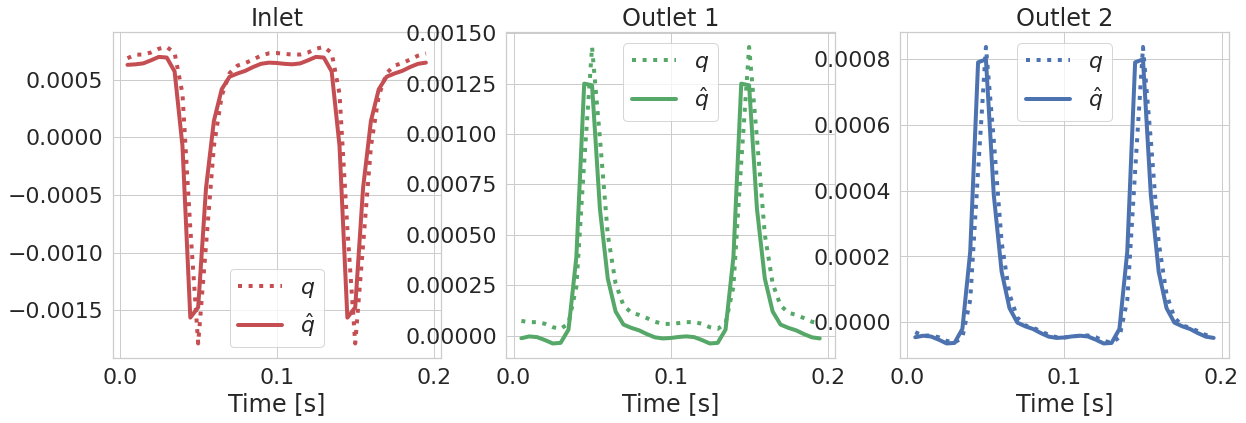

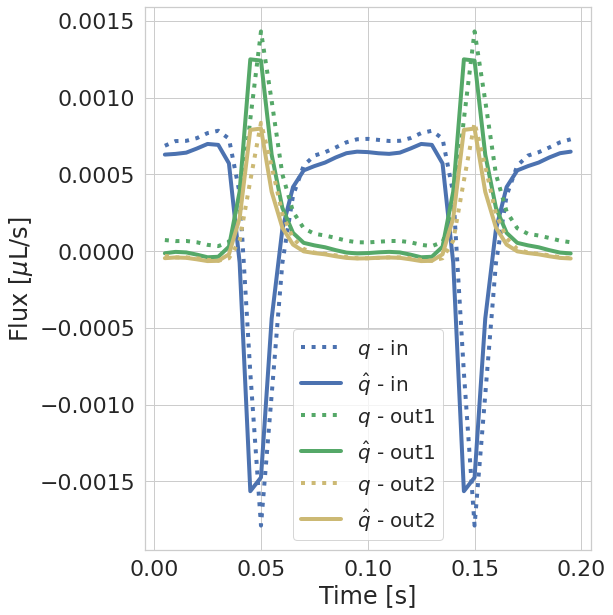

In [8]:
fig_infl, axs_infl = plt.subplots(1, 3, figsize=(20, 6))
fig_all, axs_all = plt.subplots(1, 1, figsize=(8, 10))

## -- Plot inflow
t,infl = plt.loadtxt(results_path + '3D/inflow.txt').transpose()
infl = -1*infl

x_infl = mesh_segments[0].coordinates()[-1]
q1D_infl = [q1D(x_infl) for q1D in q1Ds[0]]

axs_infl[0].plot(t,infl, 'r:', label='$q$')
axs_infl[0].plot(t,q1D_infl, 'r', label='$\hat{q}$')
axs_infl[0].legend()
axs_infl[0].set_xlabel("Time [s]")
axs_infl[0].set_title("Inlet")

## -- Plot ouflows
## Note : outflow1.txt corresponds to segment 1 and outflow0.txt corresponds to segment 2
t,out1 = plt.loadtxt(results_path + '3D/outflow1.txt').transpose()
x_out1 = mesh_segments[1].coordinates()[0]
print("x_out1 =", x_out1)
q1D_out1 = [q1D(x_out1) for q1D in q1Ds[1]]

axs_infl[1].plot(t,out1, 'g:', label='$q$')
axs_infl[1].plot(t,q1D_out1, 'g', label='$\hat{q}$')
axs_infl[1].legend()
axs_infl[1].set_xlabel("Time [s]")
axs_infl[1].set_title("Outlet 1")

t,out2 = plt.loadtxt(results_path + '3D/outflow0.txt').transpose()
x_out2 = mesh_segments[2].coordinates()[2]
print("x_out2 =", x_out2)
q1D_out2 = [q1D(x_out2) for q1D in q1Ds[2]]
axs_infl[2].plot(t,out2, 'b:', label='$q$')
axs_infl[2].plot(t,q1D_out2, 'b', label='$\hat{q}$')
axs_infl[2].legend()
axs_infl[2].set_xlabel("Time [s]")
axs_infl[2].set_title("Outlet 2")

## -- Plot flux at inlet and outlets (one plot)
axs_all.plot(t,infl, 'b:', label='$q$ - in')
axs_all.plot(t,q1D_infl, 'b', label='$\hat{q}$ - in')
axs_all.plot(t,out1, 'g:', label='$q$ - out1')
axs_all.plot(t,q1D_out1, 'g', label='$\hat{q}$ - out1')
axs_all.plot(t,out2, 'y:', label='$q$ - out2')
axs_all.plot(t,q1D_out2, 'y', label='$\hat{q}$ - out2')

axs_all.legend(fontsize=20, loc = 'lower center')
#axs_all.set_xlim(0.01,0.1)
axs_all.set_xlabel("Time [s]")
axs_all.set_ylabel("Flux [$\mu$L/s]")

print("Discrepancy (%) in = ", (abs(np.max(q1D_infl) - np.max(infl))/abs(np.max(infl)))*100)
print("Discrepancy (%) out1 = ", (abs(np.max(q1D_out1) - np.max(out1))/abs(np.max(out1)))*100)
print("Discrepancy (%) out2 = ", (abs(np.max(q1D_out2) - np.max(out2))/abs(np.max(out2)))*100)

print("Net flow (cycle 1) - 1D: ", np.sum(q1D_infl[0:20])*dt)
print("Net flow (cycle 2) - 1D: ", np.sum(q1D_infl[18:38])*dt)

print("Net flow (cycle 1) - 3D: ", np.sum(infl[0:20])*dt)
print("Net flow (cycle 2) - 3D: ", np.sum(infl[18:38])*dt)

print("min infl = ", np.min(q1D_infl))
print("max out1 = ", np.max(q1D_out1))
print("max out2 = ", np.max(q1D_out2))

**Computing 3D solutions (cross-section) averages to be compared with 1D solutions**

In [23]:
p_avg_s, q_avg_s, p1D_c_s, q1D_c_s, tang_comps = compute_1D_avg_from_3D_solution(case_path, case_prefix, results_path, coord_factor, dt)

3
0 0.0
1 0.0380977002078162
2 0.04006168160891296
3 0.04013786354903467
4 0.04093673107474173
5 0.04242356931378143
6 0.04315397730565185
7 0.040907526458068125
8 0.025252546337595137
9 0.029596794110224055
10 0.0767597833415074
11 0.038274566522929085
12 0.0053562471238368225
13 0.023499102568667964
14 0.032627427153193625
15 0.035695882955169095
16 0.03671343055628064
17 0.038132655207719746
18 0.03967446889172483
19 0.04060326235696104
20 0.04073821274382132
21 0.040435442232262184
22 0.04010373928326259
23 0.0401393699238528
24 0.04093678592503588
25 0.04242357134084223
26 0.043153977381583844
27 0.040907526460948446
28 0.025252546337705354
29 0.029596794110220846
30 0.07675978334150739
31 0.0382745665229286
32 0.005356247123836969
33 0.023499102568668183
34 0.032627427153193715
35 0.03569588295516914
36 0.03671343055628065
37 0.0381326552077198
38 0.03967446889172486
39 0.04060326235696102
0 0.0
1 0.019811921459268727
2 0.020565642970022745
3 0.020634665110828385
4 0.020425948493

**Comparing pressure and flux at relevant cross sections**

In [35]:
nsteps = len(p_avg_s[0])
print("nsteps = ", nsteps)
times = np.asarray(range(0, nsteps-1))*dt

color = ["b","r","g"]

nsteps =  40


[pressure] x =  [1.33986214 1.46189157 1.05069735] with tangent =  [ 0.85126846 -0.25236858  0.46005663]
Discrepancy (%) at peak =  1.1502638276569677
[pressure] x =  [1.71359934 1.37861612 1.06700974] with tangent =  [ 0.82802263 -0.06143145 -0.55731921]
Discrepancy (%) at peak =  4.138535911782385
[pressure] x =  [1.91944148 1.1831767  1.41275627] with tangent =  [ 0.81819864 -0.21156533  0.53459432]
Discrepancy (%) at peak =  16.39705897644029


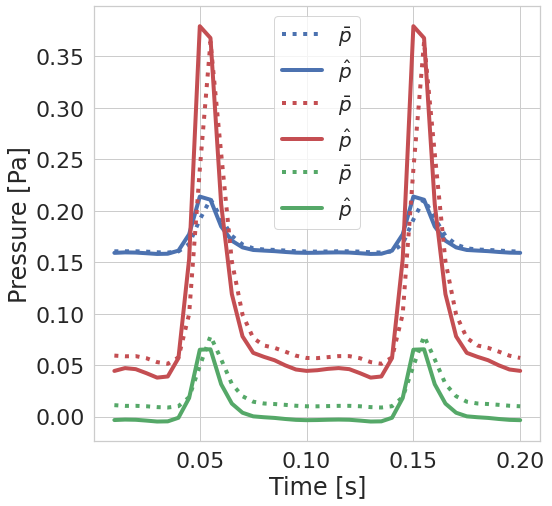

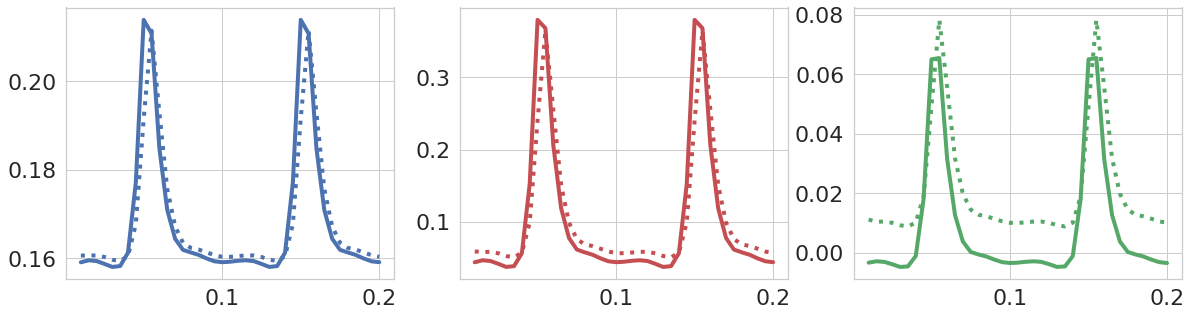

In [39]:
## Pressure and flux on specific cross-sections
fig_p2, axs_p2 = plt.subplots(1, 1, figsize=(8, 8))
fig_p, axs_p = plt.subplots(1, n_segments, figsize=(20, 5))

mesh1D_c = p_avg_s[0][0].function_space().mesh()
V1_c = FunctionSpace(mesh1D_c, 'CG', 1)

times = np.asarray(range(0, nsteps-1))*dt + 0.01

## -- Pressure -- ##
# 140: Close to the inlet
# 155 : Close to an outlet
# 60 : Close to bifurcation
cs_p = [140,60,155]
for i,cs in enumerate(cs_p):
    x_top = mesh1D_c.coordinates()[cs]
    
    # Get tangent info
    tangent = np.array([tang_comps[0](x_top), tang_comps[1](x_top), tang_comps[2](x_top)])
    print("[pressure] x = ", x_top, "with tangent = ", tangent)
    
    p_avg_top = [p_avg(x_top) for p_avg in p_avg_s[0]]
    p1D_top = [p1D(x_top) for p1D in p1D_c_s[0]]
    
    axs_p2.set_ylabel("Pressure [Pa]")
    axs_p2.set_xlabel("Time [s]")
    #axs_p2.set_xlim(0.01,0.1)

    axs_p2.plot(times, p_avg_top[1:], color[i] + ':', label='$\\bar{p}$')
    axs_p2.plot(times, p1D_top, color[i], label='$\hat{p}$')
    axs_p[i].plot(times, p_avg_top[1:], color[i] + ':', label='$\\bar{p}(s\', t)$')
    axs_p[i].plot(times, p1D_top, color[i], label='$\hat{p}(s\',t)$')
    
    # Error at peak
    print("Discrepancy (%) at peak = ", (abs(np.max(p1D_top) - np.max(p_avg_top))/abs(np.max(p_avg_top)))*100)

axs_p2.legend(fontsize=20, loc='upper center')


[flux] x =  [1.33986214 1.46189157 1.05069735] with tangent =  [ 0.85126846 -0.25236858  0.46005663]
Discrepancy (%) at peak =  1.012888200543931
[flux] x =  [1.71359934 1.37861612 1.06700974] with tangent =  [ 0.82802263 -0.06143145 -0.55731921]
Discrepancy (%) at peak =  33.501284200715276
[flux] x =  [1.91944148 1.1831767  1.41275627] with tangent =  [ 0.81819864 -0.21156533  0.53459432]
Discrepancy (%) at peak =  5.0532166060811905


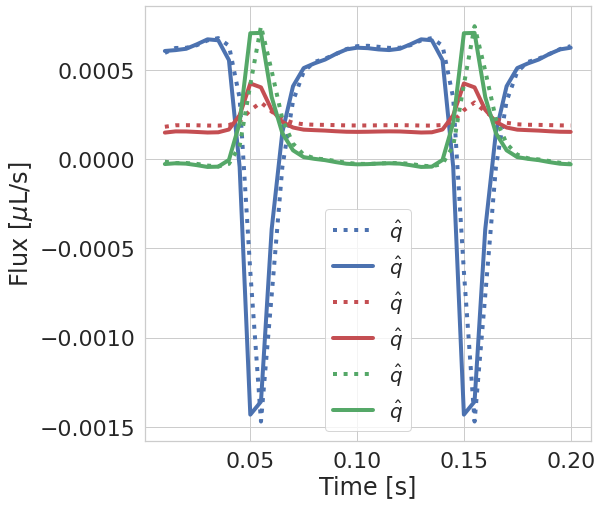

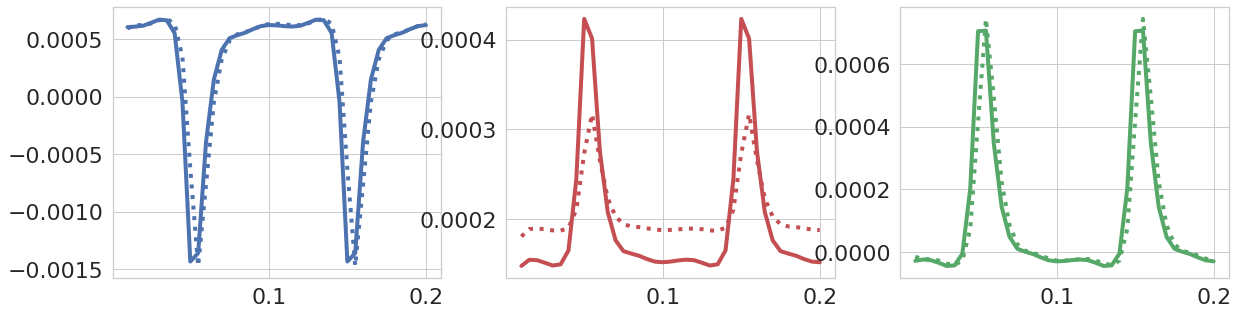

In [38]:
## -- Flux -- ##
fig_q2, axs_q2 = plt.subplots(1, 1, figsize=(8, 8))
fig_q, axs_q = plt.subplots(1, n_segments, figsize=(20, 5))

# Pt 140 on mesh = pt 50 on segment 0
# Pt 60 in mesh = pt 58 in segment 1
# Pt 155 on mesh = pt 7 on segment 2
cs_q = [50,58,7]
for i in range(n_segments):
    mesh1D_ci = Mesh()
    with XDMFFile(MPI.comm_world, results_path + "avg/XDMF/mesh1D_c_" + str(i) + ".xdmf") as xdmf:
        xdmf.read(mesh1D_ci)
    V1_ci = FunctionSpace(mesh1D_ci, 'CG', 1)

    x_top = mesh1D_ci.coordinates()[cs_q[i]]

    tangent = np.array([tang_comps[0](x_top), tang_comps[1](x_top), tang_comps[2](x_top)])
    print("[flux] x = ", x_top, "with tangent = ", tangent)

    q_avg_top = [q_avg(x_top) for q_avg in q_avg_s[i]]
    q1D_top = [q1D(x_top) for q1D in q1D_c_s[i]]

    axs_q2.set_ylabel("Flux [$\mu$L/s]")
    axs_q2.set_xlabel("Time [s]")
    #axs_q2.set_xlim(0.01,0.1)

    axs_q2.plot(times, q_avg_top[1:], color[i] + ':', label='$\hat{q}$')
    axs_q2.plot(times, q1D_top, color[i], label='$\hat{q}$')
    axs_q[i].plot(times, q_avg_top[1:], color[i] + ':', label='$q$')
    axs_q[i].plot(times, q1D_top, color[i], label='$\hat{q}$')
    
    # Error at peak
    print("Discrepancy (%) at peak = ", (abs(np.max(q1D_top) - np.max(q_avg_top))/abs(np.max(q_avg_top)))*100)
    
axs_q2.legend(fontsize=20, loc='lower center')
  